In [1]:
import itertools as iter
from itertools import product

import time

import pandas as pd
import numpy as np
import triangle as tri 

from scipy.stats import norm
from scipy.optimize import linprog

from matplotlib import pyplot as plt


from mpl_toolkits.mplot3d import Axes3D

In [2]:
def f(p): #funcion a evaluar
    x = p[0]
    y = p[1]
    f = (1/y)*((0.5*((x*x+1)*(1-norm.cdf(x))-(x*norm.pdf(x))))-(0.5*(((x+y)*(x+y)+1)*(1-norm.cdf(x+y))-((x+y)*norm.pdf(x+y)))))
    
    return f

#gsl_cdf_ugaussian_P == norm.cdf
#These functions compute the cumulative distribution functions P(x), Q(x) and their inverses for the unit Gaussian distribution.


#gsl_ran_ugaussian_pdf == norm.pdf
#These functions compute results for the unit Gaussian distribution. They are equivalent to the functions above with a standard deviation of one, sigma = 1.

def df1dx (x,y): #funcion a evaluar 
	f = (1/y)*((norm.pdf(x+y)-(x+y)*(1-norm.cdf(x+y)))-(norm.pdf(x)-x*(1-norm.cdf(x))))
	return f

def df1dy (x,y): #funcion a evaluar 
	f = -(1/(y*y))*((0.5*((x*x+1)*(1-norm.cdf(x))-(x*norm.pdf(x))))-(0.5*(((x+y)*(x+y)+1)*(1-norm.cdf(x+y))-((x+y)*norm.pdf(x+y)))))+(1/y)*(norm.pdf(x+y)-(x+y)*(1-norm.cdf(x+y)))
	return f

def gradf(p):
    x = p[0]
    y = p[1]
    return np.array([df1dx(x,y),df1dy(x,y)])
def gradf2(p):
    x = p[0]
    y = p[1]
    return np.array([df1dx(x,y),df1dy(x,y),-1.0])

def fSH(a,x):
    return f(a) + np.dot(gradf(a),(x-a))

def e_i(n,i):
    vector = np.zeros(n)
    vector[i-1] = np.ones(1)

    return vector

def pad(matriz, dimensiones):
    return np.pad(matriz,dimensiones, mode = 'constant', constant_values=(0, 0))

def linap (p,cuts, c,m):
    return max(c[str(cut)]+np.dot(m[str(cut)],p) for cut in cuts)

In [3]:
def to_points(triangulo):
    puntos = triangulo["vertices"]
    simplices = triangulo["triangles"]

    lista = []

    for pp in simplices:
        a = puntos[pp[0]]
        b = puntos[pp[1]]
        c = puntos[pp[2]]

        lista.append([a,b,c])

    return lista

def array_index(T, a):
    for i, arr in enumerate(T):
        if np.array_equal(arr, a):
            return i
    raise ValueError(f'{a} is not in list')

def triag_listo(T,v):
    a = v[0]
    b = v[1]
    c = v[2]
    
    aa = array_index(T,a)
    bb = array_index(T,b)
    cc = array_index(T,c)
    seg = [[aa,bb],[bb,cc],[cc,aa]]

    x = (a+b+c)/3
    return seg, x   

In [4]:
#Primera pasada
lb = float(1.0e-6)
ub = float(5.0)
a = np.array([0.0,lb])
b = np.array([ub,ub])
og = False

k=0

X = dict()
Y = dict()
D = dict()

data = dict()

deltaabs = np.infty
deltarel = np.infty
epsabs = float(1.0e-4) #No cambiar de 1.0e-5
epsrel = float(1.0e-4)

if not og:
    bordes = np.array([a,[0.0,ub],[ub,lb],b])
    dominio_temp = dict()

    dominio_temp["vertices"] = bordes

    triangulo_temp = tri.triangulate(dominio_temp, opts="qca0.1") #area!

    for p in triangulo_temp["vertices"]:
        k+=1
        deltaabs = max(f(p),0.0)
        deltarel = deltaabs/f(p)


        X[k] = p
        Y[k] = np.nan

        if deltaabs <= epsabs or deltarel <= epsrel:
            D[k] = 0
            Terminar = True

        data[k] = {"GEN": 0, "X": X[k],"X1" :  X[k][0], "X2" :  X[k][1], "Y": Y[k],"f(x)": f(p),"difabs": deltaabs, "difrel":deltarel}
else:
    X[k] = e_i(2,2)*float(1.0e-6) #R^2
    Y[k] = np.zeros(1) #R

    D[k] = 1

    data[k] = {"GEN": 0, "X": X[k], "X1" :  X[k][0], "X2" :  X[k][1], "Y": Y[k], "f(x)": f(X[k]), "difabs": f(a)-0.0, "difrel": 1}


    while k < 1e6:
        Terminar = False

        soluciones = dict()

        p = X[k]

        for i in [1,2]:
            for c in [lb,ub]:

                lhsA = np.array([gradf(p),
                                e_i(2,i-1)])
                rhsb = np.array([np.dot(gradf(p),p)-f(p), c])

                ecs = np.linalg.solve(lhsA,rhsb)
                way = max(fSH(p,ecs),0.0)

                if np.less_equal(a/2.0,ecs).all() and np.less_equal(ecs,b+a/2.0).all():
                    soluciones[str(ecs)] = (ecs,way)

        if len(soluciones) < 1.0:
            ecs_s = b
            way_s = max(fSH(p,b),0)
            Terminar = True

        else:
            maximo = -1*np.infty
            for key in soluciones.keys():
                val = soluciones[key]
                if val[1] > maximo:
                    maximo = val[1]
                    ecs_s = val[0]
                    way_s = maximo

        deltaabs = f(ecs_s)-way_s
        deltarel = deltaabs/f(ecs_s)

        k+=1

        X[k] = ecs_s
        Y[k] = way_s

        if deltaabs <= epsabs or deltarel <= epsrel:
            D[k] = 0
            Terminar = True

        data[k] = {"GEN": 0, "X": X[k],"X1" :  X[k][0], "X2" :  X[k][1], "Y": Y[k],"f(x)": f(p),"difabs": deltaabs, "difrel":deltarel}

        if Terminar:
            break

    df = pd.DataFrame(data).transpose()
    #Añade los vértices del cuadrado del dominio
    extremos = np.array([[0.0,ub],[ub,lb],b])
    for p in extremos:
        if p not in df["X"].values:
            k+=1
            X[k] = p
            Y[k] = 0.0
            data[k] = {"GEN": 0,"X": X[k], "X1" :  X[k][0], "X2" :  X[k][1], "Y": Y[k],"f(x)": f(p),"difabs": deltaabs, "difrel":deltarel}
df = pd.DataFrame(data).transpose()

In [5]:
df

,GEN,X,X1,X2,Y,f(x),difabs,difrel
1,0,"[0.0, 1e-06]",0.0,0.000001,NaN,0.398942,0.398942,1.0
2,0,"[0.0, 5.0]",0.0,5.0,NaN,0.05,0.05,1.0
3,0,"[5.0, 1e-06]",5.0,0.000001,NaN,0.0,0.0,1.0
4,0,"[5.0, 5.0]",5.0,5.0,NaN,0.0,0.0,1.0
5,0,"[2.5, 5.0]",2.5,5.0,NaN,0.00012,0.00012,1.0
...,...,...,...,...,...,...,...,...
218,0,"[4.469544274765183, 3.9550934165023244]",4.469544,3.955093,NaN,0.0,0.0,1.0
219,0,"[4.677702607196938, 4.677702667737459]",4.677703,4.677703,NaN,0.0,0.0,1.0
220,0,"[5.0, 4.6875000625]",5.0,4.6875,NaN,0.0,0.0,1.0
221,0,"[4.6875, 5.0]",4.6875,5.0,NaN,0.0,0.0,1.0


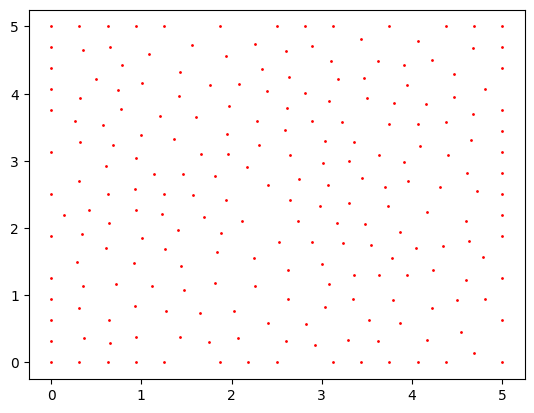

In [6]:
ex = df["X"].values.tolist()

px = []
py = []

for x in ex:
    px.append((x[0]))
    py.append((x[1]))


plt.scatter(px, py, s=1, c = "red")
plt.show()

In [7]:
dominio = dict()

vertices = df["X"].values.tolist()
holes = []
segments = [[0,1],[1,3],[3,2],[2,0]]

dominio["vertices"] = vertices
dominio["segments"] = segments
#dominio["vertices"] = []

triangulo = tri.triangulate(dominio, opts="p")

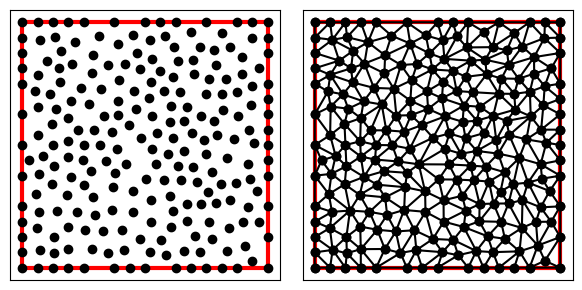

In [8]:
tri.compare(plt, dominio, triangulo)
plt.show()

C:\Users\nico_\AppData\Local\Temp\ipykernel_9572\3090187775.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vector[i-1] = np.ones(1)
C:\Users\nico_\AppData\Local\Temp\ipykernel_9572\2671951957.py:40: OptimizeWarning: Unrecognized options detected: {'tol': 1e-05, 'autoscale': True}. These will be passed to HiGHS verbatim.
  Sys = linprog(-FO, A_eq=lhsA_eq,b_eq=rhsB_eq,A_ub = lhsA_ub, b_ub = rhsB_ub, bounds = (None,None), options = {
C:\Users\nico_\AppData\Local\Temp\ipykernel_9572\2671951957.py:57: OptimizeWarning: Unrecognized options detected: {'tol': 1e-05, 'autoscale': True}. These will be passed to HiGHS verbatim.
  Sys2 = linprog(-FO2, A_eq=lhsA_eq2,b_eq=rhsB_eq2,A_ub = lhsA_ub2, b_ub = rhsB_ub2, bounds = (None,None), options = {
C:\Users\nico_\AppData\Local\Temp\ipykernel_9572\2671951957.py:93: Optimi

Número de Tanda: 1, delta = 15.8, k = 386


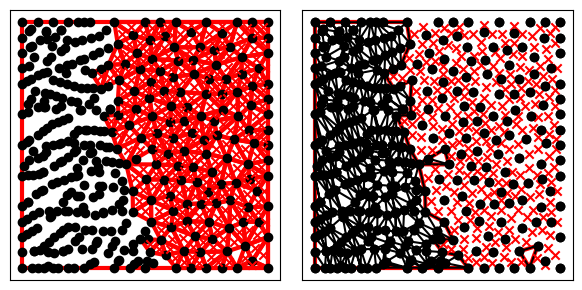

Número de Tanda: 2, delta = 19.0, k = 716


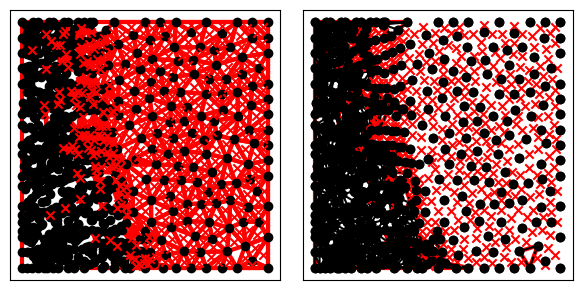

Número de Tanda: 3, delta = 28.7, k = 1199


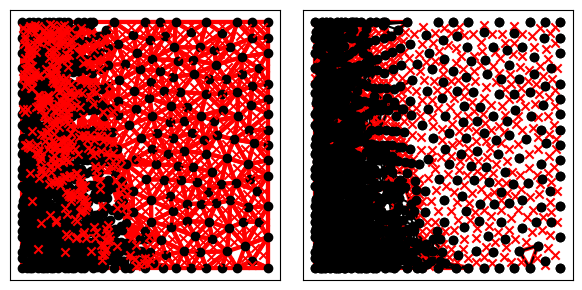

In [9]:
#Segunda pasada
tandas = [to_points(triangulo)]
lim = 1200

for simplices in tandas:
    start = time.time()
    if k+1 >= lim:
        break
    
    for simplex in simplices:
        nn = []
        Solus = []
        v = dict()
        v[1] = simplex[0]
        v[2] = simplex[1]
        v[3] = simplex[2]

        ro = np.array([v[1],
                    v[2],
                    v[3],
                    -e_i(2,1),
                    -e_i(2,2),
                        np.zeros(2)]).T
        A = np.array([gradf2(v[1]),
                    gradf2(v[2]),
                    gradf2(v[3])])
        B=  np.array([[np.dot(gradf(v[1]),v[1])-f(v[1]),
                    np.dot(gradf(v[2]),v[2])-f(v[2]),
                    np.dot(gradf(v[3]),v[3])-f(v[3])]])
        
        lhsA_eq = pad(ro,((0,1),(0,0))) + pad(np.array([e_i(6,1)+e_i(6,2)+e_i(6,3)]), ((2,0),(0,0)))
        lhsA_ub = pad(A, ((0,6),(3,0))) + pad(-np.array([e_i(6,1),e_i(6,2),e_i(6,3)]), ((3,3),(0,0)))+ pad(np.array([e_i(6,1),e_i(6,2),e_i(6,3)]), ((6,0),(0,0)))
        rhsB_eq = e_i(3,3)
        rhsB_ub = pad(B.T, ((0,6),(0,0))) + np.array([e_i(9,7)+e_i(9,8)+e_i(9,9)]).T

        FO = -e_i(6,6)
        for n in v.keys():
            FO+= e_i(6,n)*f(v[n])

        Sys = linprog(-FO, A_eq=lhsA_eq,b_eq=rhsB_eq,A_ub = lhsA_ub, b_ub = rhsB_ub, bounds = (None,None), options = {
            "tol" : 1.0e-5,
            "autoscale": True
            })
        N = []
        N2 = []
        if Sys.success:   #################
            Solus.append((Sys.x,0))
            x1 = Sys.x[0:2]
            for n in v.keys():
                lhsA_eq2 = pad(np.copy(lhsA_eq),((0,1),(0,0))) + pad(np.array([e_i(6,n)]),((3,0),(0,0)))
                rhsB_eq2 = e_i(4,3)#pad(np.copy(rhsB_eq),((0,1),(0,0)))
                    
                lhsA_ub2 = np.copy(lhsA_ub)
                rhsB_ub2 = np.copy(rhsB_ub)
                
                FO2 = np.copy(FO)
                Sys2 = linprog(-FO2, A_eq=lhsA_eq2,b_eq=rhsB_eq2,A_ub = lhsA_ub2, b_ub = rhsB_ub2, bounds = (None,None), options = {
                        "tol" : 1.0e-5,
                        "autoscale": True
                        })
                if Sys2.success:
                    Solus.append((Sys2.x,n))
                else:
                    print("Sys2 not succesful...")
                    break
                    
                rhsB_eq3 = np.copy(rhsB_eq2)
                rhsB_ub3 = np.copy(rhsB_ub2)
                    
                lhsA_ub3 = np.copy(lhsA_ub2)

                ll = Sys2.x[0:3]
                xx = Sys2.x[3:5]
                zz = Sys2.x[5]
                
                temp = np.zeros((3,2))
                temp[n-1] = xx

                contador = 1
                for m in v.keys():
                    FO3 = -e_i(6,6)
                    if m != n:
                        FO3[m] = zz
                        for l in v.keys():
                            if l !=m:
                                temp[l-1] = v[m]
                                FO3[l-1] = f(v[l])
                        
                        lhsA_eq3 = np.copy(lhsA_eq2)
                        lhsA_eq3[0:2] = np.zeros((2,6))
                        lhsA_eq3[0:2] += -pad(np.array([e_i(6,4),e_i(6,5)]),((0,0),(0,0))) + pad(temp.T,((0,0),(0,3)))

                        Sys3 = linprog(-FO3, A_eq=lhsA_eq3,b_eq=rhsB_eq3,A_ub = lhsA_ub3, b_ub = rhsB_ub3, bounds = (None,None), options = {
                            "tol" : 1.0e-5,
                            "autoscale": True
                            })
                        if not Sys3.success:
                            print("Sys3 number"+str(contador)+" not succesful...")
                            break
                        else:
                            if Sys3.fun < 1.0e-4:
                                Solus.append((Sys3.x,n))
                            else:
                                continue
                                #print("mhhhh..."+str(Sys3.fun))
                                #print(Sys3)
            #if np.less_equal(np.ones(3)*1.0e-8, Sys.x[0:3]).all(): #i.e., x \in int(\Delta)
                
        else:
            print("Por alguna razón no tiró soluciones.........")
            break
        
        maximo = -np.inf
        solucion_final = []
        for solucion,n in Solus:
            ecs = solucion[3:5]
            z = solucion[5]
            
            if f(ecs) >= maximo+z:               #QUIZAS... AGREGARLE EL CORTE Z=0? (CON UN MAX{...,0}) !!!!!!!!!!!!!!!!!!!!!!!!!!!!
                solucion_final,nn = solucion,n
                maximo = f(ecs) - z             #x2 ^

        ecs_s = solucion_final[3:5]
        way_s = solucion_final[5]

        deltaabs = f(ecs_s) - way_s
        deltarel = deltaabs/f(ecs_s)
        
        if f(ecs_s) <= epsabs+way_s or deltarel <= epsrel:
            seg, x = triag_listo(vertices, simplex)
            for s in seg:
                segments.append(s)
            holes.append(x)
            continue

        k+=1

        X[k] = ecs_s
        Y[k] = way_s

        data[k] = {"GEN": len(tandas), "X" :  X[k],"X1" :  X[k][0], "X2" :  X[k][1], "Y": Y[k],"f(x)": f(ecs_s),"difabs": deltaabs, "difrel":deltarel}

        vertices.append(ecs_s)

        if k+1 >= lim:
            break
    
    dominio["vertices"] = vertices
    dominio["segments"] = segments
    dominio["holes"] = holes
    triangulo = tri.triangulate(dominio, "p")
    print("Número de Tanda: "+str(len(tandas))+", delta = "+str(round(time.time()-start,1))+", k = "+str(k))
    tri.compare(plt, dominio, triangulo)
    plt.show()
    if len(vertices) != len(simplices):
        tandas.append(to_points(triangulo))

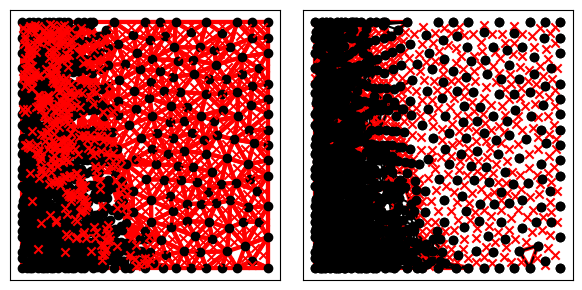

In [10]:
df2 = pd.DataFrame(data).transpose()
tri.compare(plt, dominio, triangulo)
plt.show()

In [11]:
for solucion,n in Solus:
    ecs = solucion[3:5]
    z = solucion[5]
        
    print(f(ecs)-z)

0.00011817693953511399
0.00011397595871617469
-3.469446951953614e-18
-3.469446951953614e-18
0.00011817693953511399
-1.734723475976807e-18
-3.469446951953614e-18
3.098233222940776e-05
-1.734723475976807e-18


In [12]:
print(k)
print(len(df2))
print(len(simplices))

1199
1199
1606


In [13]:
print(lhsA_eq)

[[ 1.19182017  1.10263432  1.00213228 -1.          0.          0.        ]
 [ 1.73663158  1.8785364   1.84928078  0.         -1.          0.        ]
 [ 1.          1.          1.          0.          0.          0.        ]]


In [14]:
print(rhsB_ub)

[[-0.06619862]
 [-0.07114968]
 [-0.08433743]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]]


In [15]:
#print(df2.to_markdown())

### POR QUE HAY VALORES NEGATIVOS?

Por mientras, los parchearé a la mala...

C:\Users\nico_\AppData\Local\Temp\ipykernel_9572\4216198164.py:7: RuntimeWarning: divide by zero encountered in log10
  px.append(np.log10(x[0]))


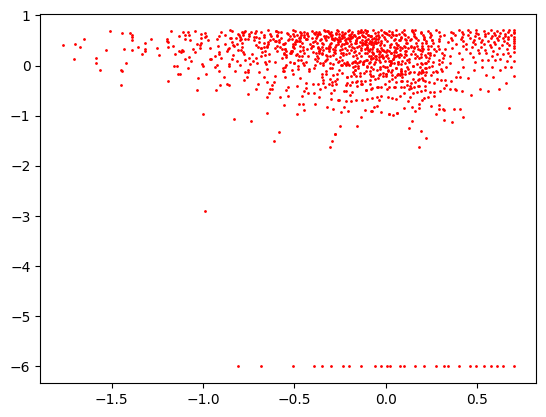

In [16]:
ex = df2["X"].values.tolist()

px = []
py = []

for x in ex:
    px.append(np.log10(x[0]))
    py.append(np.log10(x[1]))


plt.scatter(px, py, s=1, c = "red")
plt.show()

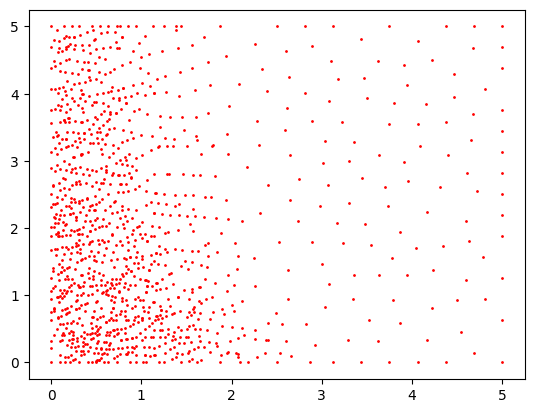

In [17]:
ex = df2["X"].values.tolist()

px = []
py = []

for x in ex:
    px.append(x[0])
    py.append(x[1])


plt.scatter(px, py, s=1, c = "red")
plt.show()

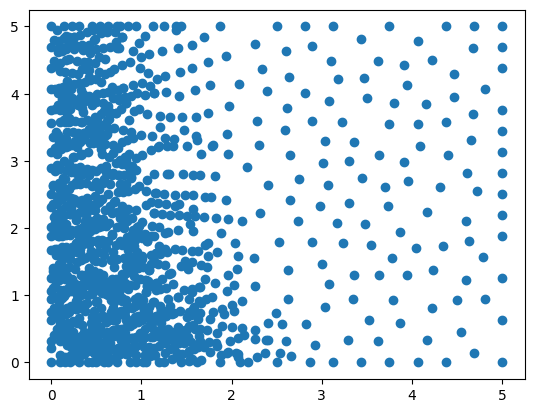

In [18]:
pepes = df2["X"].values.tolist()

pepes = np.array(pepes)

tri2 = tri.triangulate({"vertices": pepes}, "c")
plt.plot(pepes[:,0], pepes[:,1], 'o')
plt.show()

In [19]:
print(len(df2)-len(df), len(df))

977 222


In [20]:
puntox1  = np.random.rand(1000,2)*(ub-lb)+lb
puntox2  = []

for n in puntox1:
    puntox2.append(np.array([n[0], n[1], f(n)]))
puntox2 = np.array(puntox2)


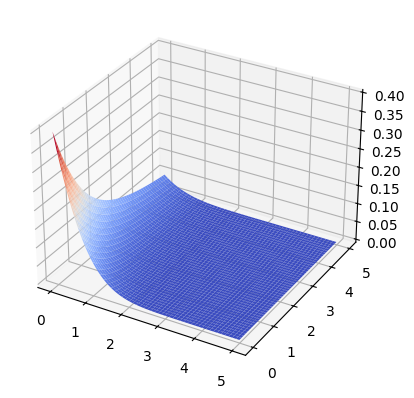

In [21]:
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

#X = puntox2[:,0]
X = np.arange(lb, ub, 0.01)
Y = np.arange(lb, ub, 0.01)
#Y = puntox2[:,1]

X,Y = np.meshgrid(X,Y)

Z = f((X,Y))

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)

plt.show()


In [22]:
Teacher_cuts = pd.read_excel(r'C:\Users\nico_\Desktop\mem\Codigos\profe\Code_C_shortage_barrido\cortes.xlsx', header = 0).iloc[:,1:3]

In [23]:
Teacher_cuts

,param x1:=,param y1:=
0,x,y
1,0,0.000001
2,0,1.596001
3,0,3.486001
4,1.12,0.000001
...,...,...
1997,1.158,0.951001
1998,0.326,1.490001
1999,2.046,1.885001
2000,0.027,1.219001


C:\Users\nico_\AppData\Local\Temp\ipykernel_9572\3059026019.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  px.append(x[0])
C:\Users\nico_\AppData\Local\Temp\ipykernel_9572\3059026019.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  py.append(x[1])


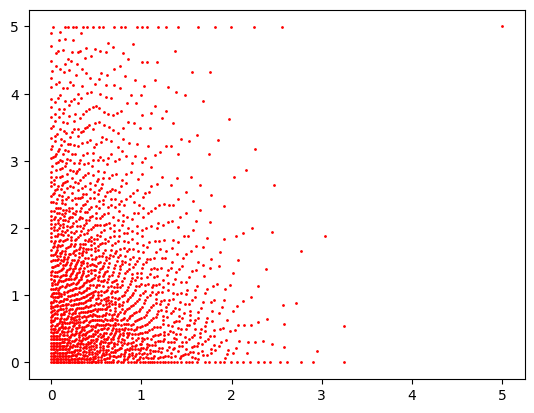

C:\Users\nico_\AppData\Local\Temp\ipykernel_9572\3059026019.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if x[0] == 0:
C:\Users\nico_\AppData\Local\Temp\ipykernel_9572\3059026019.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  px2.append(np.log10(x[0]))
C:\Users\nico_\AppData\Local\Temp\ipykernel_9572\3059026019.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  py2.append(np.log10(x[1]))


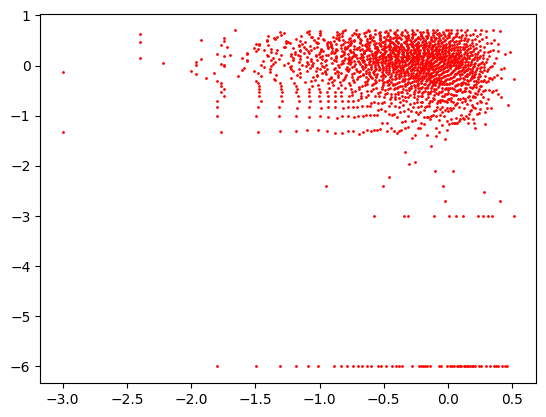

In [24]:
px = []
px2 = []
py = []
py2 = []

for n in Teacher_cuts.index:
    if n > 0:
        x = Teacher_cuts.iloc[n]
        px.append(x[0])
        py.append(x[1])

px.append(ub)
py.append(ub)
plt.scatter(px, py, s=1, c = "red")
plt.show()

for n in Teacher_cuts.index:
    if n > 0:
        x = Teacher_cuts.iloc[n]
        if x[0] == 0:
            continue
        px2.append(np.log10(x[0]))
        py2.append(np.log10(x[1]))


plt.scatter(px2, py2, s=1, c = "red")
plt.show()

In [25]:
print()

## Comprobación ##


In [26]:
my_cuts = df2.iloc[:,1:4]

In [27]:
cuts = my_cuts.iloc[:,0].values

c = dict()
m = dict()

for cut in cuts:
    c[str(cut)] = f(cut) - np.dot(gradf(cut),(cut))
    m[str(cut)] = gradf(cut)

In [28]:
for n in range(0,100,1):
    linap(np.array([2,2]),cuts,c,m)

In [29]:
n=33

contador = 0
h = (ub-lb)/n
doomx = []
doomy = []

x = 0.0
while x < ub:
    y = lb
    while y < ub:
        z = linap(np.array([x,y]),cuts,c,m)
        if f((x,y)) >= epsabs + z:
            doomx.append(x)
            doomy.append(y)
            contador+=1
        y+= h
    x+= h

In [30]:
contador/n**2

0.011937557392102846

# $Old$

2k cortes: 3.84%

1k cortes: 7.52%

500 cortes: 12.48%

250 cortes: 19.68%


# $New$

2k cortes: 0.00%

1k cortes: 2.47%

500 cortes: 9.36%

250 cortes: 17.91%

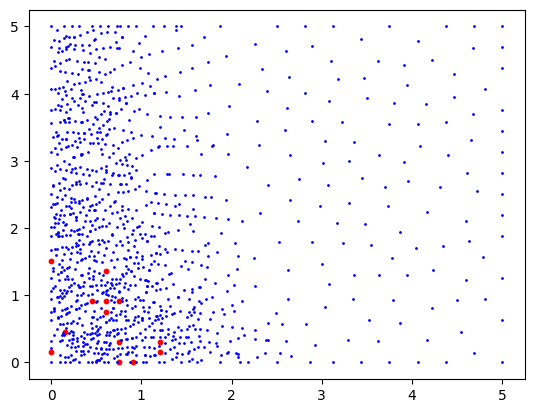

In [31]:
px = []
py = []

for n in range(len(doomx)):
    x = doomx[n]
    y = doomy[n]
    px.append(x)
    py.append(y)

plt.scatter(px, py, s=10, c = "red")


plt.scatter(df2["X1"], df2["X2"], s=1, c = "blue")
plt.show()